In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from itertools import combinations
import cartopy.crs as ccrs
import 

In [3]:
rawdf = pd.read_excel("./Evaporation_Experiment.xlsx")
rawdf.columns = rawdf.columns.str.strip()

infodf = pd.read_csv("./sampleinfo.csv")

In [15]:
nonignore = rawdf[rawdf['Ignore'] == 0]
nonignore.loc[:, 'Time Code'] = nonignore['Time Code'].str.strip()

nonignore.loc[:, 'Time Code'] = pd.to_datetime(nonignore['Time Code'], format='%Y/%m/%d %H:%M:%S')

samples = nonignore.groupby("Identifier 1")



cal_17_16 = {
    'DY-2': -12.22,
    'BOTTY': -3.88,
    'SPIT-2': -0.09
}

cal_18_16 = {
    'DY-2': -23.08,
    'BOTTY': -7.40,
    'SPIT-2': -0.15
}

cal_D_H = {
    'DY-2': -180.47,
    'BOTTY': -50.38,
    'SPIT-2': -0.44
}

isotopes = ['17_16','18_16','D_H']

cal_dicts = {'17_16': cal_17_16, '18_16': cal_18_16, 'D_H': cal_D_H}

skipnum = 0

Error on DY-2 17_16 -7.739629629629624
Error on BOTTY 17_16 -7.436259259259262
Error on SPIT-2 17_16 -7.311037037037037
Error on DY-2 18_16 -14.458481481481478
Error on BOTTY 18_16 -14.015537037037033
Error on SPIT-2 18_16 -13.85537037037037
Error on DY-2 D_H 85.60148148148149
Error on BOTTY D_H 106.22133333333333
Error on SPIT-2 D_H 112.4654074074074


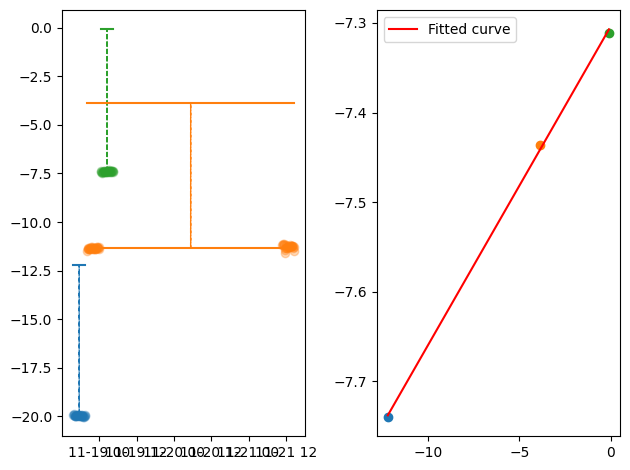

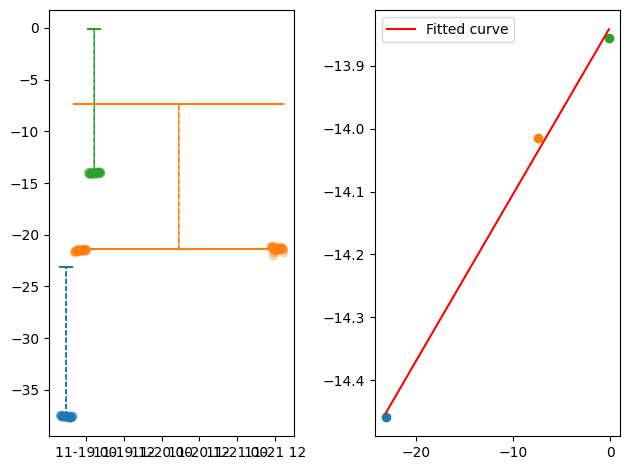

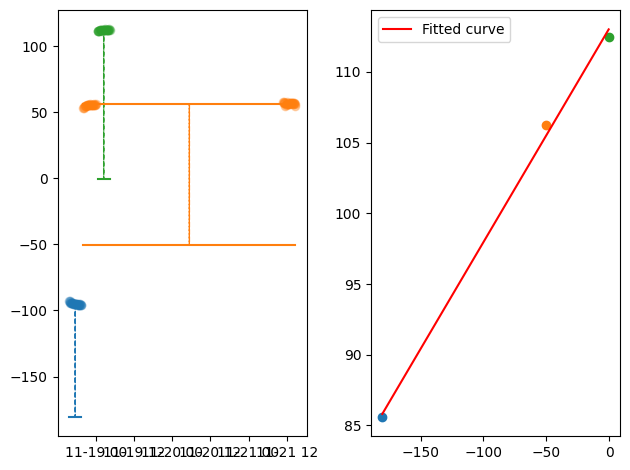

In [20]:
def line_fit(a,b,x):
    return a*x + b

fitsdict = {}

for iso in isotopes:
    cal_data = cal_dicts[iso]
    
    sample_cal = {name.strip(): group for name, 
                  group in samples if name.strip() in cal_data.keys()}

    fig, ax = plt.subplots(ncols=2)

    i=0
    fit_dict = []

    for name, group in sample_cal.items():
        ax[0].scatter(group['Time Code'][skipnum:], group[f'd({iso})Mean'][skipnum:], alpha=0.3)
        ax[0].plot([group['Time Code'][skipnum:].min(),group['Time Code'][skipnum:].max()],
                [cal_data[name],cal_data[name]], c=f'C{i}')
        ax[0].plot([group['Time Code'][skipnum:].min(),group['Time Code'][skipnum:].max()],
                [group[f'd({iso})Mean'][skipnum:].mean(),group[f'd({iso})Mean'][skipnum:].mean()], c=f'C{i}')

        ax[0].arrow(x = pd.to_datetime((group['Time Code'][skipnum:].min().timestamp() + group['Time Code'][skipnum:].max().timestamp()) / 2, unit='s'),
                 y = cal_data[name],
                 dx = 0,
                 dy = - cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean(),
                 color = f'C{i}', ls="--")

        print('Error on',name,iso,- cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean())
        
        i+=1

        ax[1].scatter(cal_data[name], - cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean())

        fit_dict.append([cal_data[name], - cal_data[name] + group[f'd({iso})Mean'][skipnum:].mean()])

    xdata = np.array([i[0] for i in fit_dict])
    ydata = np.array([i[1] for i in fit_dict])

    # Perform curve fitting
    popt, pcov = curve_fit(line_fit, xdata, ydata)

    # Optional: Plot the fitted curve
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = line_fit(x_fit, *popt)
    ax[1].plot(x_fit, y_fit, color='r', label='Fitted curve')
    ax[1].legend()

    plt.tight_layout()

    fitsdict[iso] = popt

In [21]:
means_dict = {i:{} for i in isotopes}

for sample in samples:
    for iso in isotopes:
        # print((labels[sample[0].strip()] if sample[0].strip() in labels else 'STD'), f'{iso}:', np.mean(sample[1][f'd({iso})Mean'][skipnum:]))
        means_dict[iso][sample[0].strip()] = np.mean(sample[1][f'd({iso})Mean'][skipnum:])

[('D_H', '18_16'), ('D_H', '17_16'), ('18_16', '17_16')]


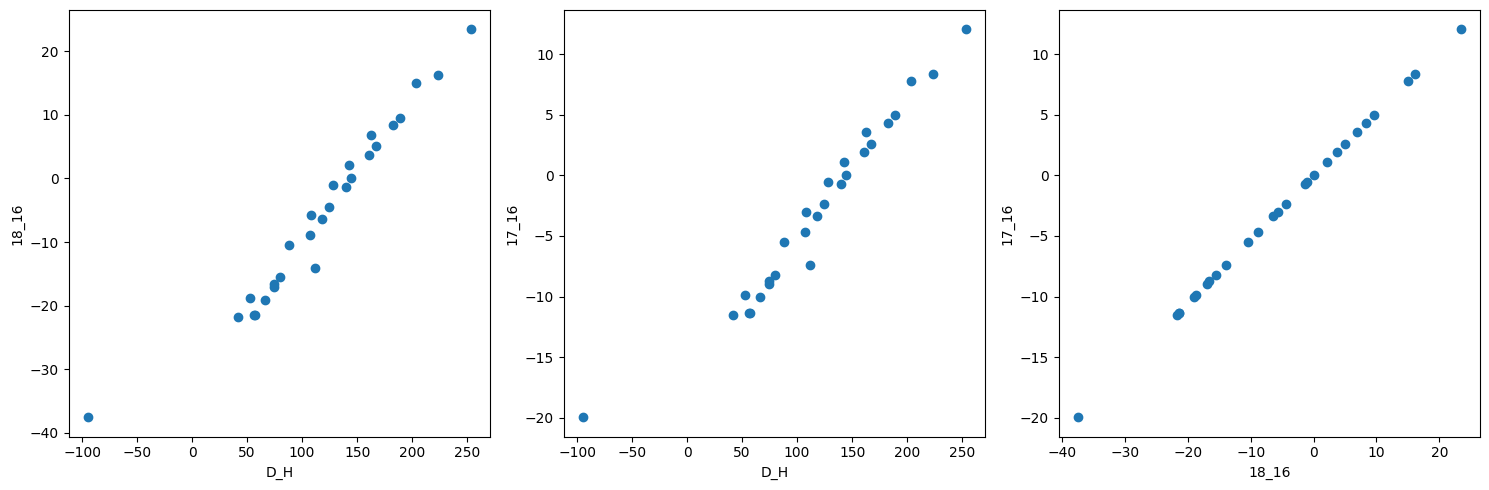

In [24]:
# Pairwise isotope plots (not excess, just linear!)

iso_pairs = list(combinations(isotopes[::-1], 2))

print(iso_pairs)

fig, ax = plt.subplots(ncols=3, figsize=(15,5))

for i, pair in enumerate(iso_pairs):
    ax[i].scatter(means_dict[pair[0]].values(), means_dict[pair[1]].values())

    ax[i].set_ylabel(pair[1])
    ax[i].set_xlabel(pair[0])

plt.tight_layout()